In [185]:
#python3
#import libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import os
from auxiliary_functions import *
import seaborn as sns
from scipy.fft import fft, fftfreq
#testing the complex exponential version of this
import cmath
sns.set()
sns.set_style('white')
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

In [186]:
#define some functions
def convert_to_name(selector):
    if selector==0:
        return "droving"
    elif selector==1:
        return "mustering"
    elif selector==2:
        return "driving"
    else:
        return None 
    
#maybe we can find omega by taking the derivatives
def omega_counter(x_array, y_array):
    dy = [y_array[ii]-y_array[ii-1] for ii in range(len(y_array))]
    dx = [x_array[ii]-x_array[ii-1] for ii in range(len(y_array))]
    derivative = dy #[dy[ii]/dx[ii] for ii in range(len(fit_y_data_herd))]

    #calculate omega 
    omega_counter = 0
    for ii in range(len(derivative)):
        if derivative[ii-1] >0:
            if derivative[ii] <0:
                omega_counter+=1
        if derivative[ii-1] <0:
            if derivative[ii] >0:
                omega_counter+=1
    #print(omega_counter)
    
    return omega_counter

0
Looking at data & performing sanity checks...
There are  50 sheep!
There are  1 dogs!
There are 1429 frames of dumped data!
(2, 500)
average_angle:  2.285140300285172
Dog net velocity:  0.12694225371006124
Rx=0.04, Ry=0.16, v=0.13, w=4.78


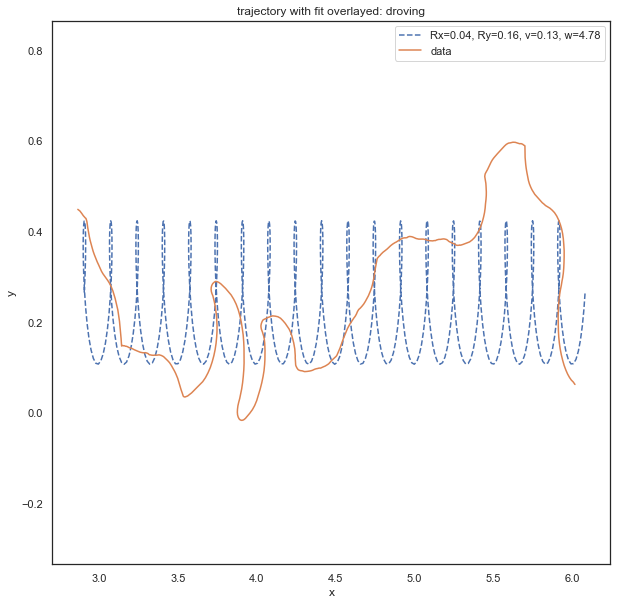

1
Looking at data & performing sanity checks...
There are  100 sheep!
There are  1 dogs!
There are 9759 frames of dumped data!
(2, 2000)
average_angle:  2.08527876030163
Dog net velocity:  0.017115378619422125
Rx=0.21, Ry=0.19, v=0.02, w=0.5


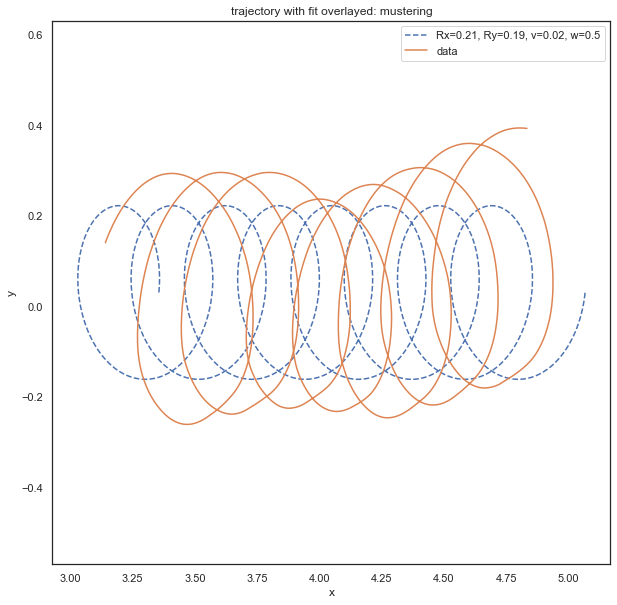

2
Looking at data & performing sanity checks...
There are  200 sheep!
There are  1 dogs!
There are 1496 frames of dumped data!
(2, 400)
average_angle:  2.5587346324352285
Dog net velocity:  0.09775125757101193
Rx=0.0, Ry=0.0, v=0.1, w=26.7


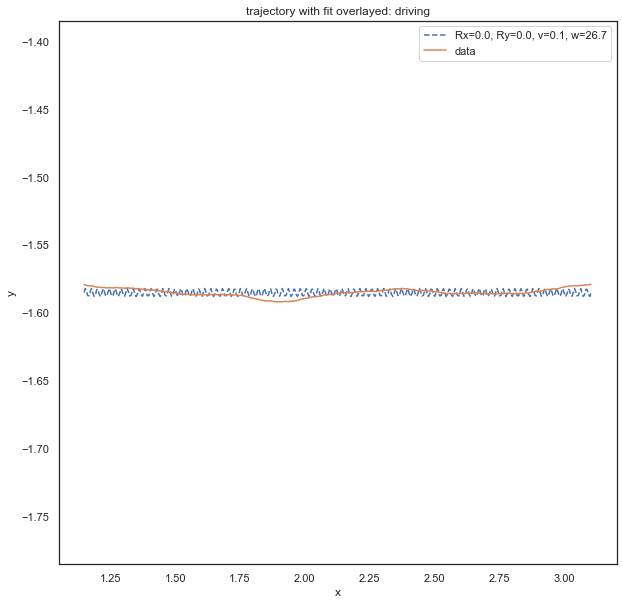

In [268]:
#for selector in range(3):
for selector in range(3):
    
    print(selector)
    #set_up_directories
    parent_folder = '/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/paper_outputs/SI_ABM_videos/'
    sub_folders = ['droving_slow', 'mustering_slow', 'driving']
    change_dir_to = parent_folder + sub_folders[selector]
    os.chdir(change_dir_to)
    
    L = 6 #size of domain to plot
    dt = 0.05 #manually setting the timestep size (should eventually be grabbed from load_params_auto)

    #start timing
    t0 = time.time()


    #temporary function to load the data from the costdata file
    costdata_full_array = np.loadtxt('costdata.txt')
    l4_norm  = costdata_full_array[:,3]
    dog_on = 1 #we want to look at the dog not the herd?
    
    if selector == 0:
        sp = 900
        sl= 500
        droving_outputs = setup_variables(1, sp, sl, mainplots=1) #fit_x, fit_y, fit_params, data_output
    elif selector == 1:
        sp = 5000
        sl = 2000
        mustering_outputs = setup_variables(1, sp, sl, mainplots=1) #fit_x, fit_y, fit_params, data_output
    elif selector ==2:
        sp = 600
        sl = 400
        driving_outputs = setup_variables(1, sp, sl, mainplots=1) #fit_x, fit_y, fit_params, data_output
    
    

In [243]:
def setup_variables(dog_on, sp, sl, subplots =0, mainplots=1):
    
    #load in the data
    #load info from data file
    dat_field = np.loadtxt('data.txt')
    #load the parameter files
    driving_on, x_target, y_target, vs, vd, ls, ld, fence, num_particles, ndogs, modder = load_params_auto('params.txt')
    xpart, ypart, thetapart, x_dogs, y_dogs, dat_times, timesteps, times, = load_data(dat_field, num_particles)
    sanity_checks(dat_field, num_particles, ndogs, timesteps)
    
    #calculate mean sheep trajectory
    temp_times = np.linspace(0, sl*dt, sl) #define a new timescale
    xmeans = np.zeros(timesteps)
    ymeans = np.zeros(timesteps)

    for i in range(timesteps):
        index = num_particles*i
        tmp_x = xpart[index: index+num_particles]
        tmp_y = ypart[index: index+num_particles]
        xmeans[i] = np.mean(tmp_x)
        ymeans[i] = np.mean(tmp_y)
        
    #calculate dog trajectory at each time step
    xdogs = x_dogs[::num_particles][:-1]
    ydogs = y_dogs[::num_particles][:-1]
    
    window_length = np.int(sl/10)
    
#     x_temp_unfiltered = xdogs[sp:sp+sl]
#     y_temp_unfiltered = ydogs[sp:sp+sl]
    
    
    #take the moving average of the data
    temp_array_dog = np.zeros((2,sl))
    temp_array_herd = np.zeros((2,sl))
    vel_dogs = np.zeros((2,sl))
    vel_herd = np.zeros((2,sl))
    average_vel = np.zeros(2)
    
    for kk in range(sl):
        start_sequence = sp+kk
        temp_array_dog[0,kk] = np.average(xdogs[start_sequence: start_sequence+window_length])
        temp_array_dog[1,kk] = np.average(ydogs[start_sequence: start_sequence+window_length])
        temp_array_herd[0,kk] = np.average(xmeans[start_sequence: start_sequence+window_length])
        temp_array_herd[1,kk] = np.average(ymeans[start_sequence: start_sequence+window_length])
    
    print(np.shape(temp_array_dog))

    #now calculate the average angle of transport 
    average_vel_angle = np.zeros(2)    
    if dog_on == 1:
        delta_x_temp = np.average(temp_array_dog[0,-window_length:])-np.average(temp_array_dog[0,:window_length])
        delta_y_temp = np.average(temp_array_dog[1,-window_length:])-np.average(temp_array_dog[1,:window_length])

    else:
        delta_x_temp = np.average(temp_array_herd[0,-window_length:])-np.average(temp_array_herd[0,:window_length])
        delta_y_temp = np.average(temp_array_herd[1,-window_length:])-np.average(temp_array_herd[1,:window_length])

    average_angle = np.arctan2(delta_y_temp, delta_x_temp)
    
    print("average_angle: ", average_angle)

    #reset variable names (being messy for the moment)
    xdogs = temp_array_dog[0]
    ydogs = temp_array_dog[1]
    xmeans = temp_array_herd[0]
    ymeans = temp_array_herd[1]
    
    #rotate_and_scale_system
    average_angle = 2*np.pi-average_angle
    x_rot_dog = xdogs*np.cos(average_angle)-ydogs*np.sin(average_angle)
    y_rot_dog = xdogs*np.sin(average_angle)+ydogs*np.cos(average_angle)
    x_rot_mean = xmeans*np.cos(average_angle)-ymeans*np.sin(average_angle)
    y_rot_mean = xmeans*np.sin(average_angle)+ymeans*np.cos(average_angle)

    
    #calculate fit params----------------------
    if dog_on ==1:
        #calculate the average speed--for the dog
        net_displacement_dog = np.sqrt((x_rot_dog[-1]-x_rot_dog[0])**2+(y_rot_dog[-1]-y_rot_dog[0])**2)
        net_velocity_dog = net_displacement_dog/(sl*dt)
        print("Dog net velocity: ", net_velocity_dog)
        #calculate the R's
        x_shifter_dog = [net_velocity_dog*t for t in temp_times] #for the dog
        x_temp_dog = x_rot_dog-x_shifter_dog
        R_x = np.std(x_temp_dog)
        R_y = np.std(y_rot_dog)
    
 
        net_velocity = net_velocity_dog
    
        #use the arrays to calculate omega
        omega = np.pi/(temp_times[-1]/omega_counter(x_rot_dog, y_rot_dog))
        
        #set the data
        data_output = [x_rot_dog, y_rot_dog]
        
        fit_y = R_y*np.sin(omega*temp_times)+np.average(y_rot_dog)
        fit_x = R_x*np.cos(omega*temp_times)+net_velocity*temp_times+x_rot_dog[0]
        
        
    else:
        #calculate the average speed--for the herd
        net_displacement_herd = np.sqrt((x_rot_mean[-1]-x_rot_mean[0])**2+(y_rot_mean[-1]-y_rot_mean[0])**2)
        net_velocity_herd = net_displacement_herd/(sl*dt)
        print("Herd net velocity: ", net_velocity_herd)
        #calculate the R's
        x_shifter_herd = [net_velocity_herd*t for t in temp_times] #for the herd
        x_temp_herd = x_rot_mean-x_shifter_herd
        R_x = np.std(x_temp_herd) #np.abs(np.max(x_temp_herd)-np.min(x_temp_herd))
        R_y = np.std(y_rot_mean) #np.abs(np.max(y_rot_mean)-np.min(y_rot_mean))/2
        
        net_velocity = net_velocity_herd
        
        #use the arrays
        omega = np.pi/(temp_times[-1]/omega_counter(x_rot_mean, y_rot_mean)) #missing factor of 2 because we don't want to double count peaks+valleys

         #set the data
        data_output = [x_rot_mean, y_rot_mean]
        
        fit_y = R_y*np.sin(omega*temp_times)+np.average(y_rot_mean)
        fit_x = R_x*np.cos(omega*temp_times)+net_velocity*temp_times+x_rot_mean[0]
 
    #prepare outputs
    fit_params = [R_x, R_y, net_velocity, omega]

    #make some plots
    if subplots == 1:
        plt.figure(figsize = (10,10))
        fig_title = "parametric trajectory with fit overlayed: "+convert_to_name(selector)
        plt.title(fig_title)
        plt.plot(temp_times, data_output[1], label = 'y-t data')
        plt.plot(temp_times, fit_y, label = 'y-t fit')
        plt.xlabel("time")
        plt.ylabel("position")
        plt.legend()
        plt.plot()
        
    if mainplots==1:
        fitlabel ="Rx={}, Ry={}, v={}, w={}".format(np.round(R_x,2),np.round(R_y,2),
                                                              np.round(net_velocity,2), np.round(omega,2))
        print(fitlabel)
        plt.figure(figsize=(10,10))
        fig_title = "trajectory with fit overlayed: "+convert_to_name(selector)
        plt.title(fig_title)
        plt.plot(fit_x, fit_y, '--', label = fitlabel)
        plt.plot(data_output[0], data_output[1], label = 'data')
#         plt.plot(x_temp_unfiltered, y_temp_unfiltered, label = 'raw data') #unfiltered data
        midpoint_y = np.average(data_output[1])
        y_multiplier = 2
        plt.ylim(midpoint_y-y_multiplier*ld, midpoint_y+y_multiplier*ld)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        name = "cat_trans_plot_" +convert_to_name(selector)+".png"
        plt.savefig(name)
        plt.show()
    

    return fit_x, fit_y, fit_params, data_output

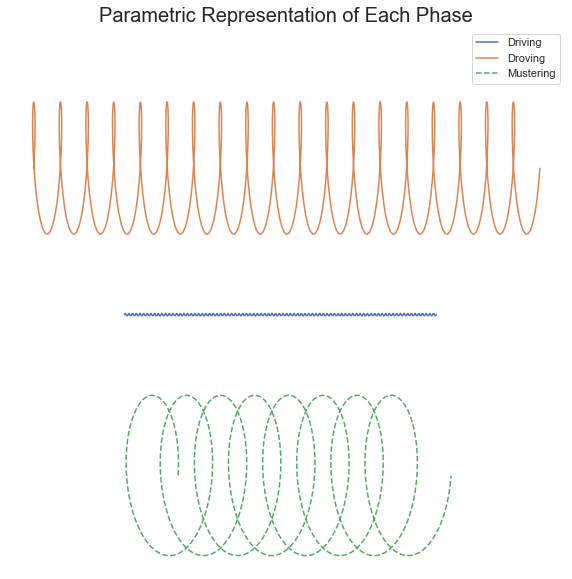

In [292]:
#create trajectory plots for fig

plt.figure(figsize=(10,10))
fig_title = "Parametric Representation of Each Phase"
plt.title(fig_title, size=20)
plt.plot(driving_outputs[0]-np.mean(driving_outputs[0]), driving_outputs[1]+1.5, label = "Driving")
plt.plot(droving_outputs[0]-np.mean(droving_outputs[0]), droving_outputs[1], label = "Droving")
plt.plot(mustering_outputs[0]-np.mean(mustering_outputs[0]), mustering_outputs[1]-0.5, '--', label = "Mustering")
plt.ylim(-0.7,0.6)
plt.axis("off")
# plt.xlabel("x")
# plt.ylabel("y")
plt.legend()
name = "/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/paper_outputs/SI_ABM_videos/SI_fits.png"
plt.savefig(name)
plt.show()

In [280]:
!OPEN .

# Things to do:

## Find a suitable region of time -- DONE
## Extract the average velocity, v -- DONE
## Rotate the x and y datapoints by theta_avg_herd -- done
## Curve fitting --argh!!!!!